# Recap

### Векторные представления

#### Что нужно сделать, чтобы получить векторные представления слов?

#### Как происходит преобразование текста в эмбэддинги?

# [nn.Embeddings](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

In [ ]:
# dict
word1 -> 0
word2 -> 1
word3 -> 3


мама мыла раму -> [ 101 , 555, 1678 ] -> [ [ 0.1, 0.004... ], [ ...], [ ... ] ]

In [ ]:
(num_embeddings x emb_dim)[i, :]

In [ ]:
import torch
import torch.nn as nn
from string import ascii_lowercase

tokens_batch = torch.tensor([ 0, 1, 2 ])

nn_embeddings = nn.Embedding(num_embeddings=len(ascii_lowercase), embedding_dim=100)

tokens_batch_embedded = nn_embeddings(tokens_batch)
tokens_batch_embedded.shape

torch.Size([3, 100])

# RNN

### PyTorch Реализация

In [7]:
import torch.nn as nn
import torch
?nn.RNN

In [6]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)

h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

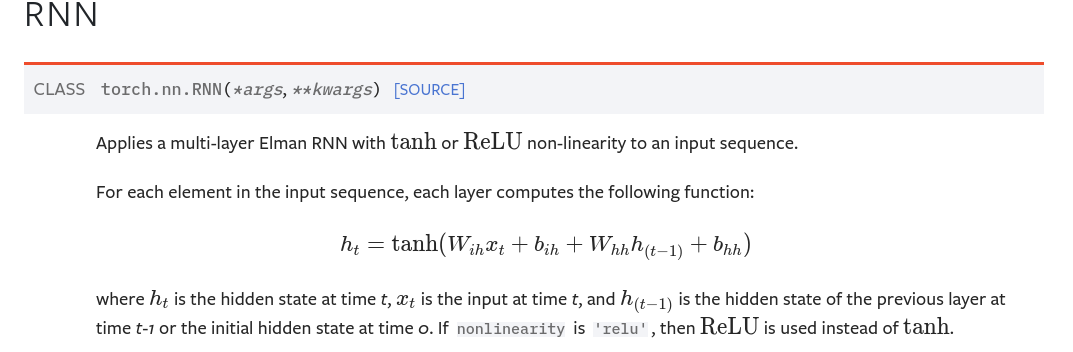

##### Что такое `output` и `hn`?

In [ ]:
# seq_len, batch_size, hidden_dim
output.shape

torch.Size([5, 3, 20])

In [ ]:
# D * num_layers, batch_size, hidden_dim
# where D = 2 if bidirectional else 1
hn.shape

torch.Size([2, 3, 20])

In [ ]:
(output[-1, :, :] == hn[-1, :, :]).all()

tensor(True)

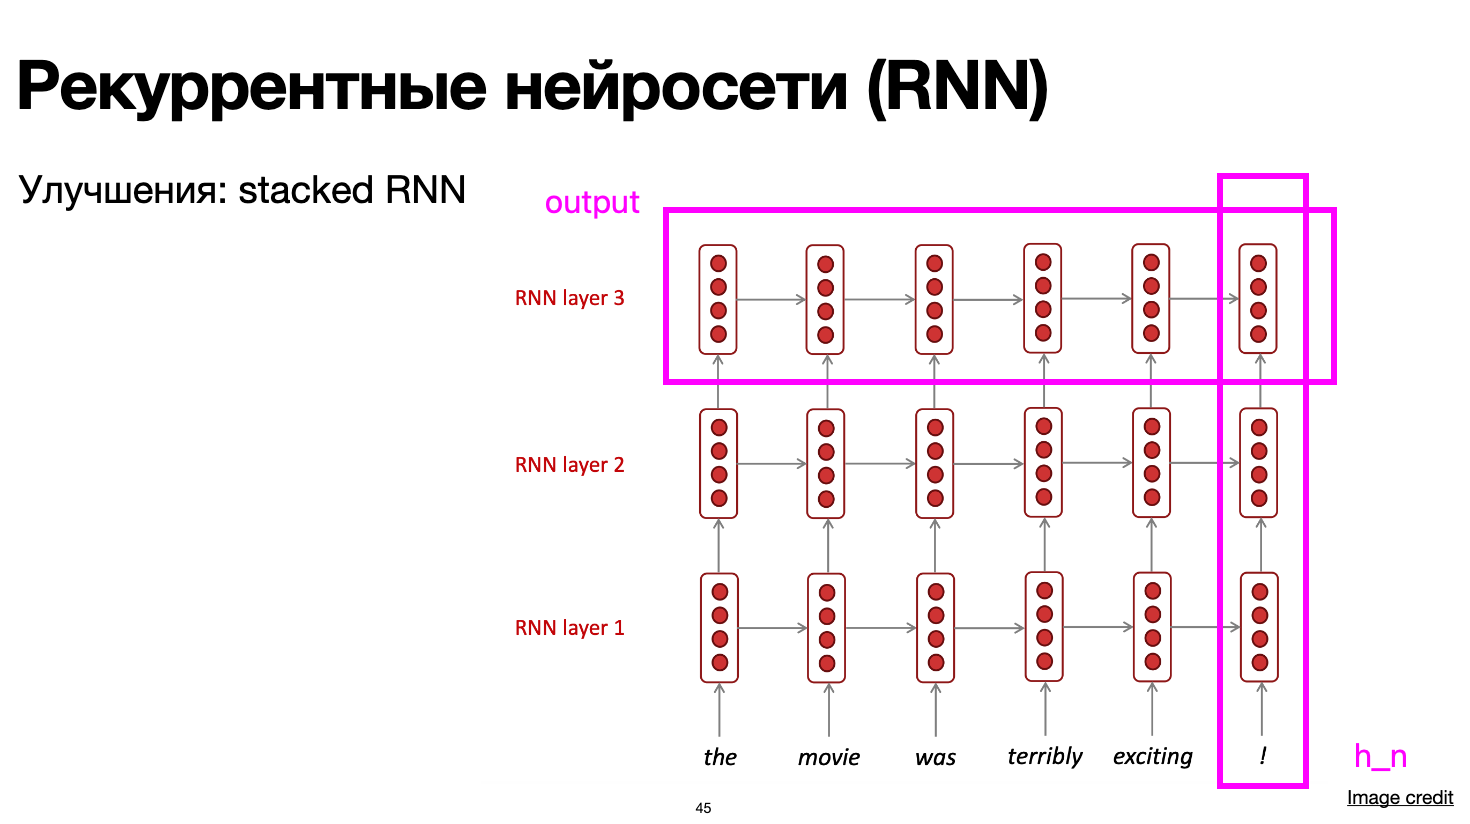

#### Посмотрим, какие параметры есть в RNN

In [3]:
# (W_ih W_hh, b_ih, b_hh) * 2

parameters_names = [ 'W_ih', 'W_hh', 'b_ih', 'b_hh' ] * 2
for name, p_shape in zip(parameters_names, list(map(lambda x: x.shape, rnn.parameters()))):
    print(name, ":", p_shape)

W_ih : torch.Size([20, 10])
W_hh : torch.Size([20, 20])
b_ih : torch.Size([20])
b_hh : torch.Size([20])
W_ih : torch.Size([20, 20])
W_hh : torch.Size([20, 20])
b_ih : torch.Size([20])
b_hh : torch.Size([20])


In [4]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_params(rnn)

1480

### Своя реализация

In [ ]:
import torch.nn as nn

class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(MyRNN, self).__init__()

        assert num_layers == 1, "num_layers > 1 not implemented"

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # input [ seq_len, batch_size, input_dim ]
        # hidden [ D * num_layers, hidden_dim ] # here always D * num_layers == 1

        output = []

        for i in range(input.shape[0]):
            output.append(hidden)

            # for n in self.n_layers
            #                      W_i2h + b_i2h          +  W_h2h + b_h2h
            hidden = torch.tanh( self.i2h(input[i, :, :]) + self.h2h(hidden) )

        output = torch.cat(output) # [ seq-len, bs, hid_dim, n layers ]

        return output, hidden

n_hidden = 128
n_letters = 26
n_categories = 10
rnn = MyRNN(n_letters, n_hidden, n_categories)

# [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)

In [ ]:
lstm = nn.LSTM(10, 20, 2)

input = torch.randn(5, 3, 10)   # [ seq_len, batch_size, input_dim ]
h0 = torch.randn(2, 3, 20)      # [ num_layers * D, batch_size, hidden_dim ] # where D=2 if bidirectional else 1
c0 = torch.randn(2, 3, 20)      # shape like h0
output, (hn, cn) = lstm(input, (h0, c0))

In [ ]:
output.shape, hn.shape, cn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]), torch.Size([2, 3, 20]))

In [ ]:
(output[-1, :, :] == hn[-1, :, :]).all()

tensor(True)

In [ ]:
count_params(lstm)

5920

# [nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU)

In [ ]:
gru = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = gru(input, h0)

In [ ]:
output.shape, hn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]))

In [ ]:
count_params(gru)

4440

**Вопрос** Для каких задач сейчас возможно имеет смысл использовать RNN?


```
Для не очень длинных последовательностей, в условиях ограниченных вычислительных ресурсов
```


# Transformer

**Paper:**: [**Attention is all you need**](https://arxiv.org/abs/1706.03762)

## Семейства трансформеров

Вообще говоря, семейстро трансформеров делится на 3 типа:

- 1) **Encoder-Decoder Transformer** - Мы сегодня рассмотрим только его. Генеративная модель. С этой архитектуры началась эпоха трансформеров.
- 2) **Encoder-Only Transformer** - BERT, RoBERTa. Используются как дискриминативные модели.
- 3) **Decoder-Only Transformer** - GPT2, Llama. Сейчас самая популярная архитектура трансформеров. Генеративная модель.


## Encoder-Decoder Transformer

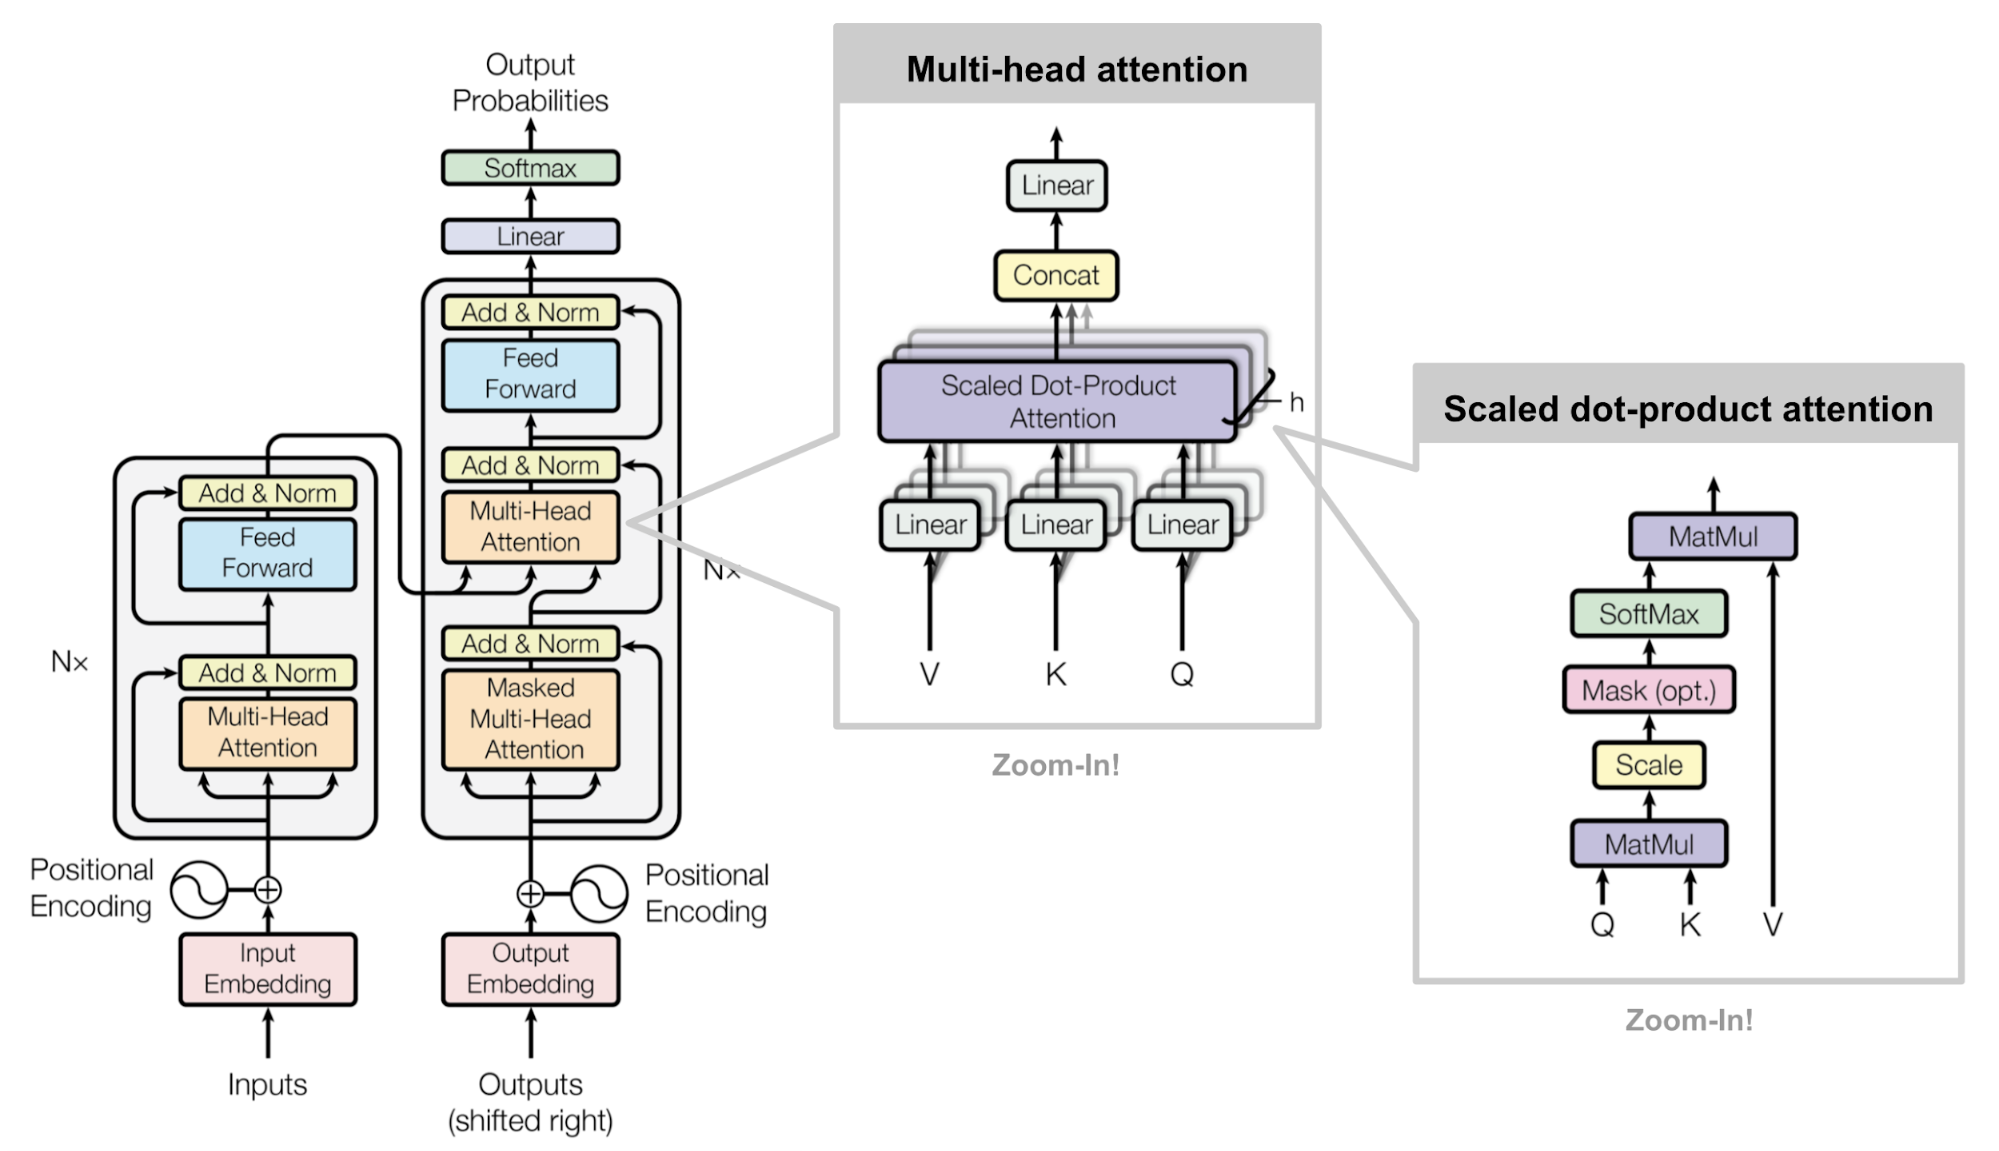

## Input Embeddings

In [ ]:
# 40M Params!
embeddings = nn.Embedding(50257, 768)

embeddings

## Attention

Compute attention weights and write the output context vector.
Keep in mind the formula of Attention function in transformers:

                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$     

In [ ]:
from torch.nn.functional import softmax
import torch
import torch.nn as nn
import math

#                          Embeddings
def self_attention_function(x, w_query, w_key, w_value):

    q = x @ w_query     # [ bs, seq_len, query_dim ]
    k = x @ w_key       # [ bs, seq_len, key_dim ]
    v = x @ w_value     # [ bs, seq_len, value_dim ]

    qkt = (q @ k.T)     # [ bs, seq_len, seq_len ]
    qk_scaled = softmax(qkt / math.sqrt(k.size(1)), dim=-1) # [ bs, seq_len, seq_len ]
    context_vector = qk_scaled @ v # [ bs, seq_len, value_dim ]

    return context_vector


Чаще всего `{q,k,v}_dim`  выбирают  одинаковыми

In [ ]:
# cross attention
#                       D      E    E
def attention_function( query, key, value, w_key, w_query, w_value):

    assert (key == value).all()

    q = query @ w_query     # [ bs, q_seq_len, attn_dim ]
    k = key   @ w_key       # [ bs, kv_seq_len, attn_dim ]
    v = value @ w_value     # [ bs, kv_seq_len, attn_dim ]

    qkt = (q @ k.T)     # [ bs, q_seq_len, kv_seq_len ]
    qk_scaled = softmax(qkt / math.sqrt(k.size(1)), dim=-1) # [ bs, q_seq_len, kv_seq_len ]

    # как тут перемножаются размерности? какие размерности должны быть одинаковыми?
    context_vector = qk_scaled @ v # [ bs, q_seq_len, value_dim ]

    return context_vector


In [ ]:

encoder_embeddings = ... # mytransformer.encode( sequence_embeddings )
decoder_embeddings = ... # mytransformer.decoder.self_attention( target_embeddings )

q, k, v = decoder_embeddings, encoder_embeddings, encoder_embeddings

attention_function( q, k, v , w_key, w_query, w_value)


#### Masked Attention

##### Why?
* decoder lookahead


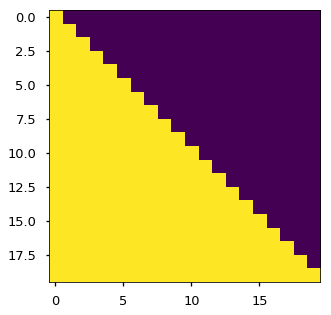

In [ ]:
def attention_function( query, key, value, w_key, w_query, w_value, mask=None):

    q = query @ w_query     # [ bs, q_seq_len, query_dim ]
    k = key   @ w_key       # [ bs, k_seq_len, key_dim ]
    v = value @ w_value     # [ bs, v_seq_len, value_dim ]

    qkt = (q @ k.T)     # [ bs, q_seq_len, k_seq_len ]
    qk_scaled = softmax(qkt / math.sqrt(k.size(1)), dim=-1) # [ bs, q_seq_len, k_seq_len ]

    if mask is not None:
        qk_scaled = qk_scaled.masked_fill(mask == 0, 0)

    context_vector = qk_scaled @ v # [ bs, (src|tgt)_seq_len, value_dim ]

    return context_vector


## MultiHeadAttention

Одна голова хорошо, а 8 лучше, идея как при инициализации большого колва ядер свертки в `Conv2d`



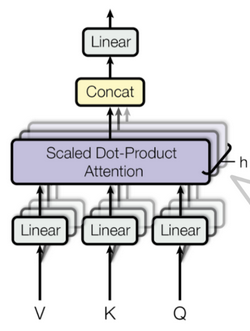

## Attention visualization



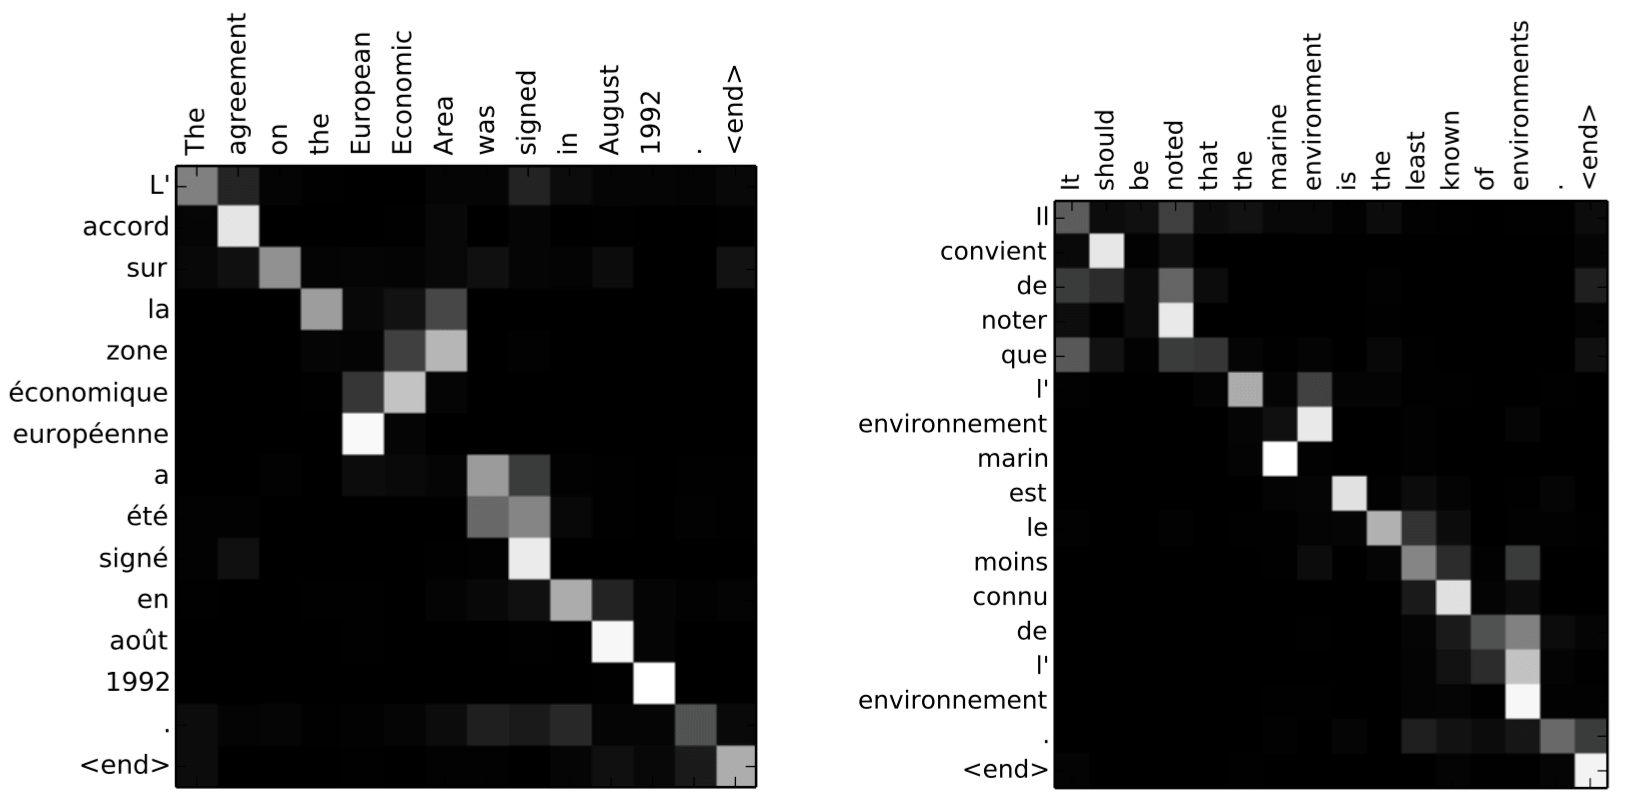

## [Transformer Encoder](https://pytorch.org/docs/master/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder)

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)
out = transformer_encoder(src)

encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
count_params(encoder_layer) # 3M

3152384

## [Transformer Decoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html)

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512) # encoder hidden state
tgt = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)

decoder_layer

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
)

In [ ]:
count_params(decoder_layer) # 4M

## [Transofrmer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)

In [ ]:
import torch
import torch.nn as nn
transformer_model = nn.Transformer(nhead=8, num_encoder_layers=6, num_decoder_layers=6)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)

transformer_model

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o

In [ ]:
# Трансформер 6 блоков, всего параметров (без эмбэддингов) = 44M
count_params( nn.Transformer(nhead=8, num_encoder_layers=6, num_decoder_layers=6) )

44140544

In [ ]:
# сколько всего параметров в механизме внимания в модели?
# 1M * (num_encoders + 2 * num_decoders)
count_params( transformer_model.decoder.layers[0].multihead_attn )

1050624

# Positional Embeddings

## Learned Positional Embeddings

* ✔️ Очень простой подход
* ❌ Не может работать с позициями, которые отсутствовали в обучающей выборке


## Positional Embeddings

В механизме внимания нет никакой информации о позициях разных токенов.

В оригинальной статье была предложена детерменированная ф-я.

* ✔️ Может работать с позициями, которые отсутствовали в обучающей выборке
* ❌ Делает это плохо


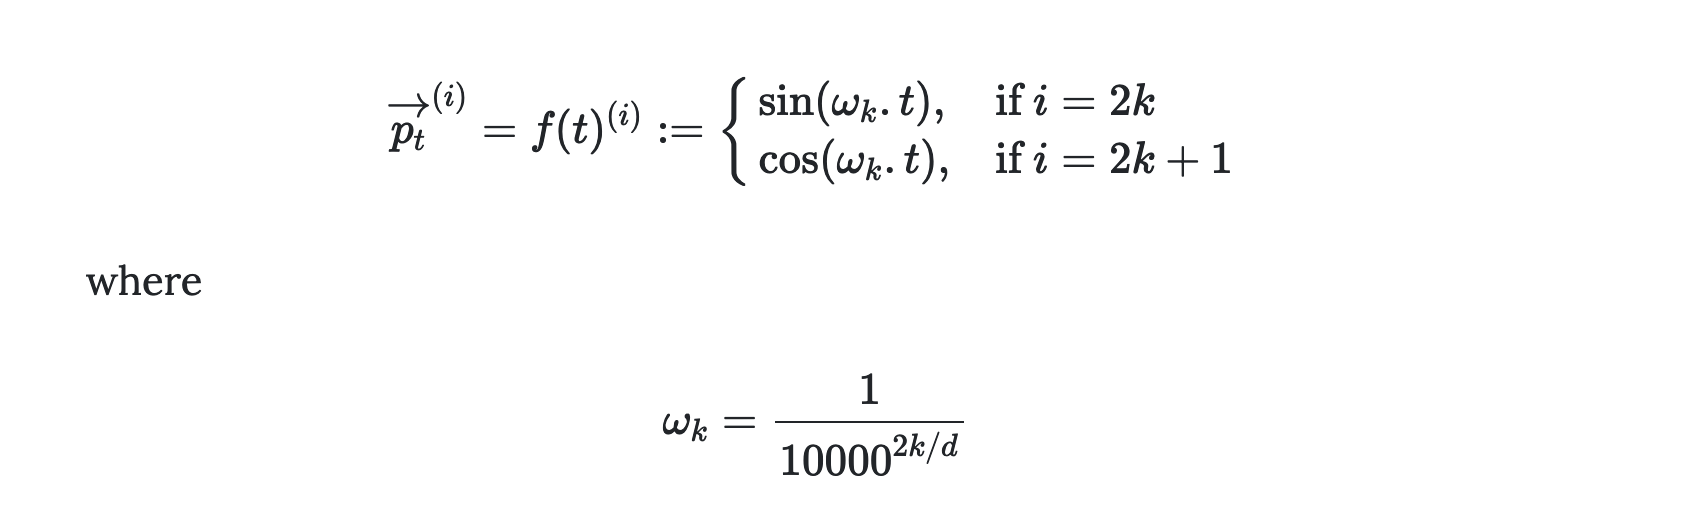

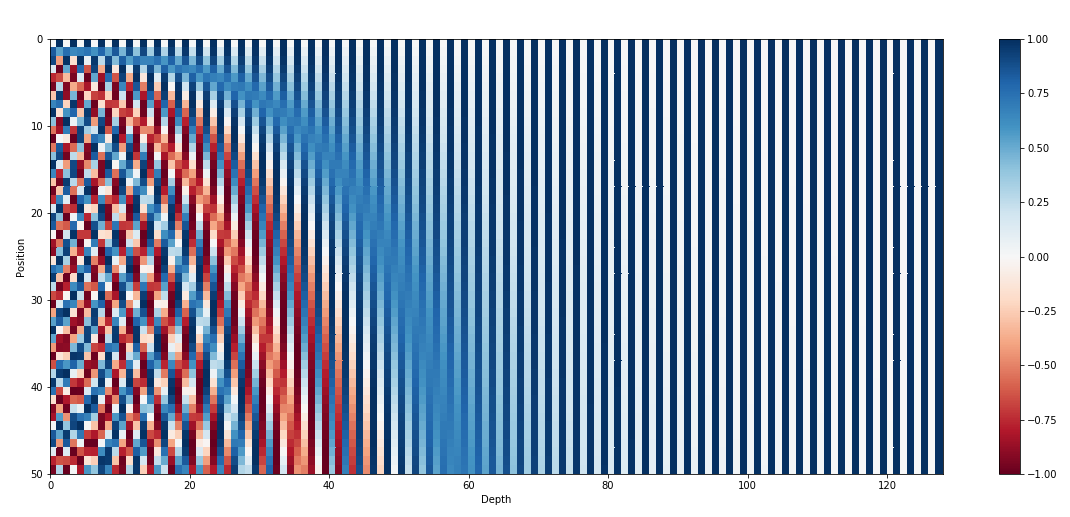

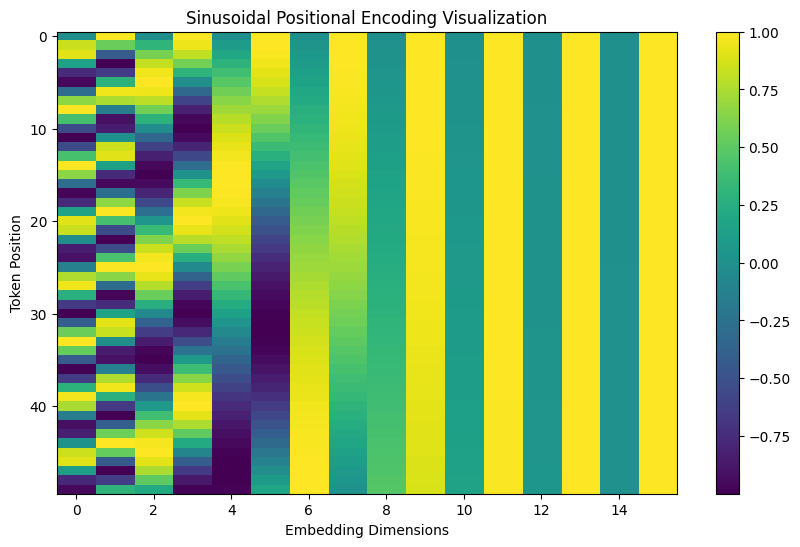

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_sinusoidal_positional_encoding(seq_len, d_model):
    """Generate sinusoidal positional encoding."""
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)

    return torch.tensor(pe, dtype=torch.float32)

# Define sequence length and model dimension
seq_len = 50   # Number of positions (e.g., words in a sentence)
d_model = 16   # Embedding size (must be even)

# Get positional encoding
pos_encoding = get_sinusoidal_positional_encoding(seq_len, d_model)

# Plot positional encodings for visualization
plt.figure(figsize=(10, 6))
plt.imshow(pos_encoding.numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Sinusoidal Positional Encoding Visualization")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Token Position")
plt.show()

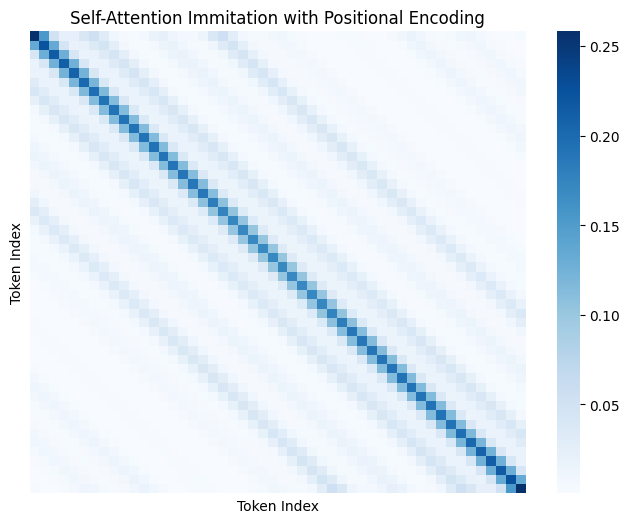

In [6]:
seq_len = 50

encoded_tokens = pos_encoding[:seq_len, :]

# Simulate self-attention scores using dot product of encoded tokens
attention_scores = torch.matmul(encoded_tokens, encoded_tokens.T)

# Normalize attention scores
attention_scores = torch.nn.functional.softmax(attention_scores, dim=-1)

# Visualize attention scores
plt.figure(figsize=(8, 6))
sns.heatmap(attention_scores.numpy(), cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Self-Attention Immitation with Positional Encoding")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.show()


## RoPE - Rotary Positional Embeddings

* ✔️ Применяются в модуле механизма внимания **на каждом слое**
* ✔️ Может работать с более длинными последовательностями ([YaRN](https://arxiv.org/abs/2309.00071))
* ✔️ Предпочтительный бейзлайн для выбора позиционных эмбэддингов


[**Annotated RoPE**](https://nn.labml.ai/transformers/rope/index.html)


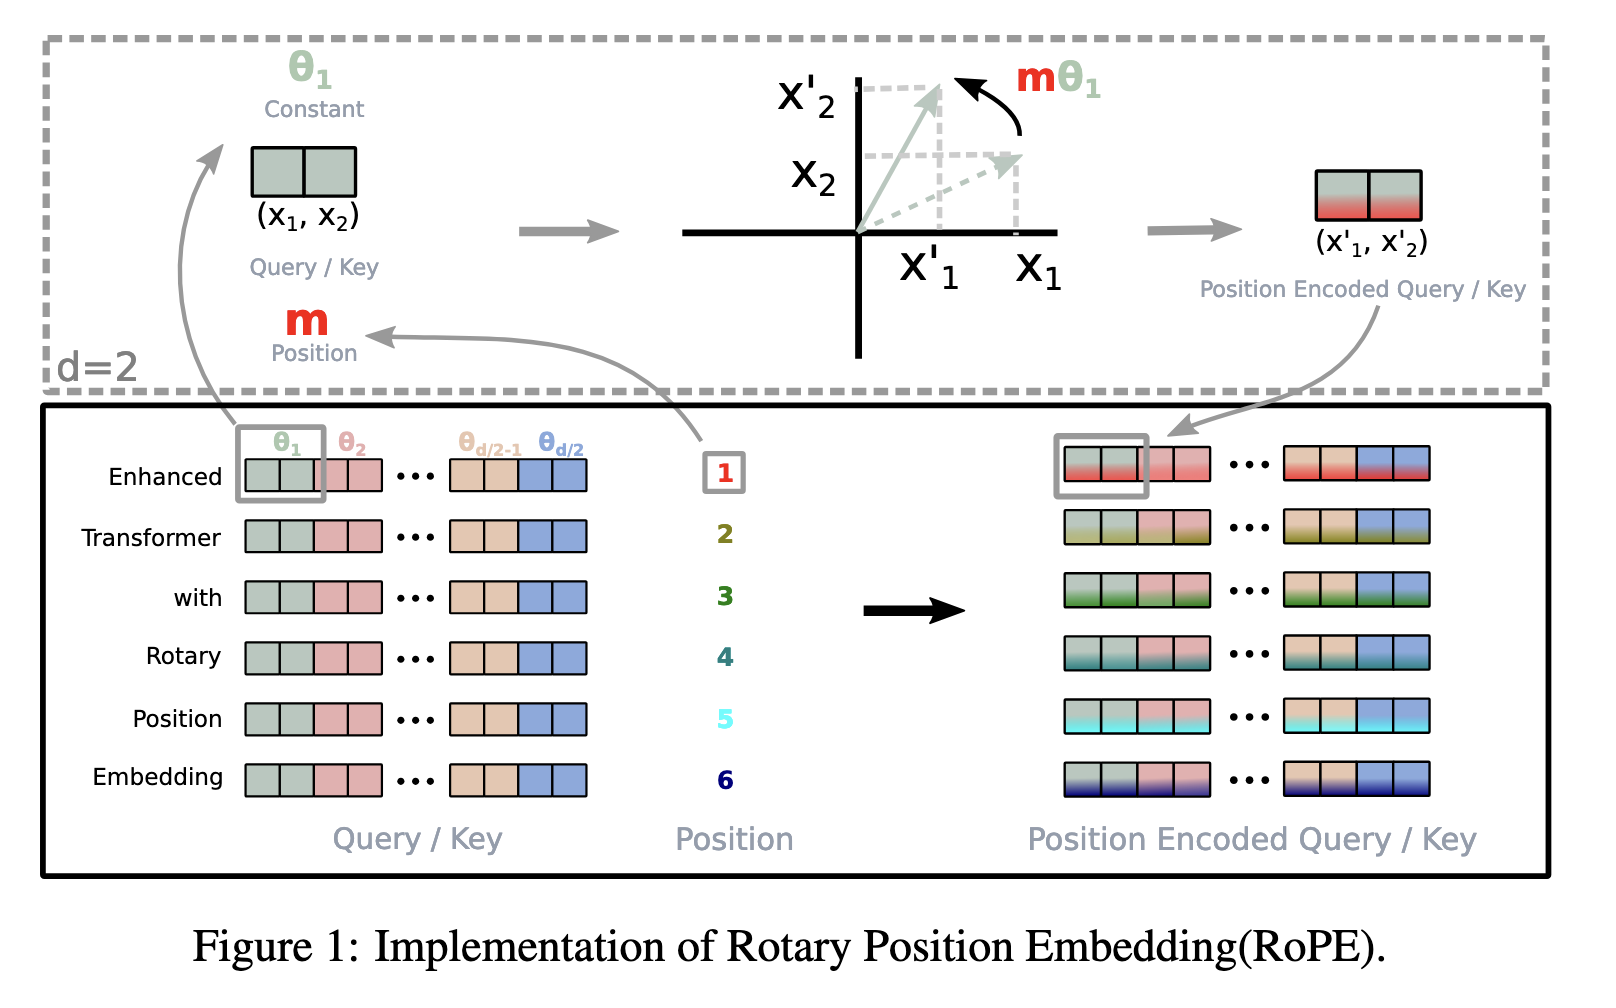

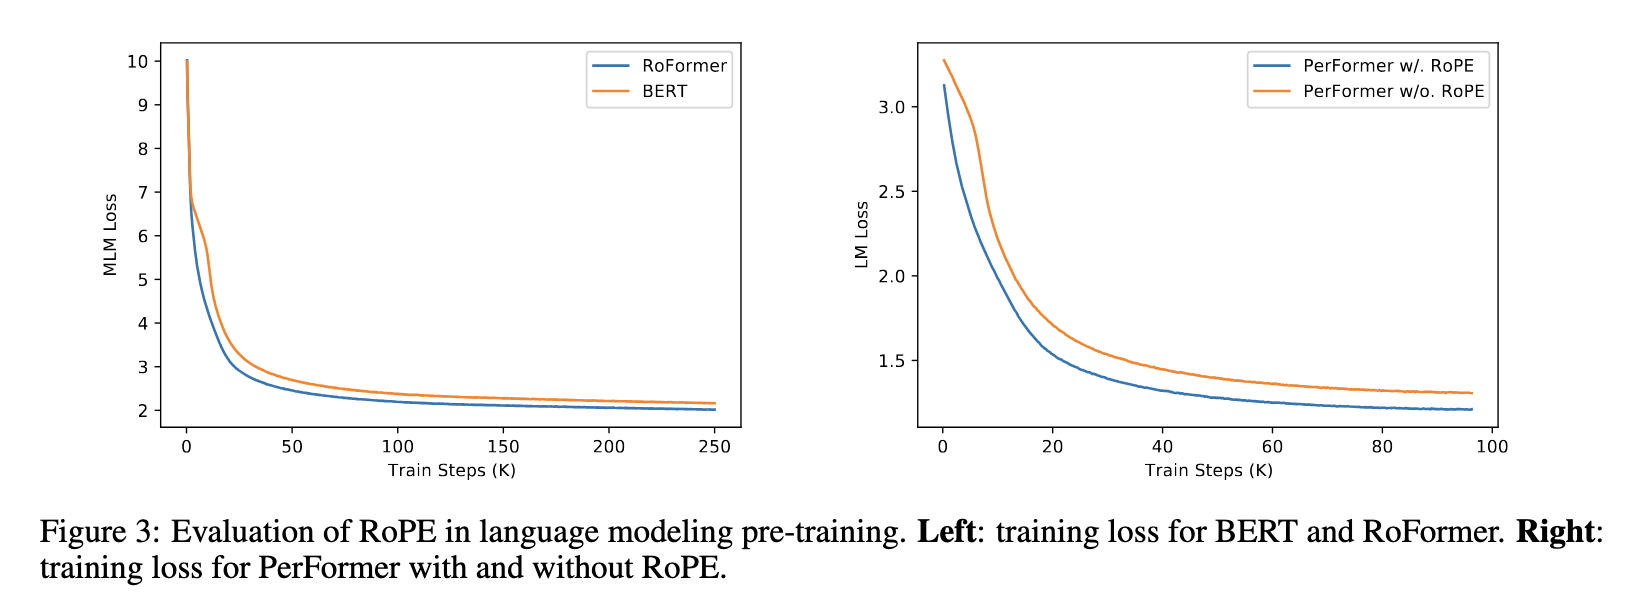

Original Token Embeddings Shape: torch.Size([50, 64])


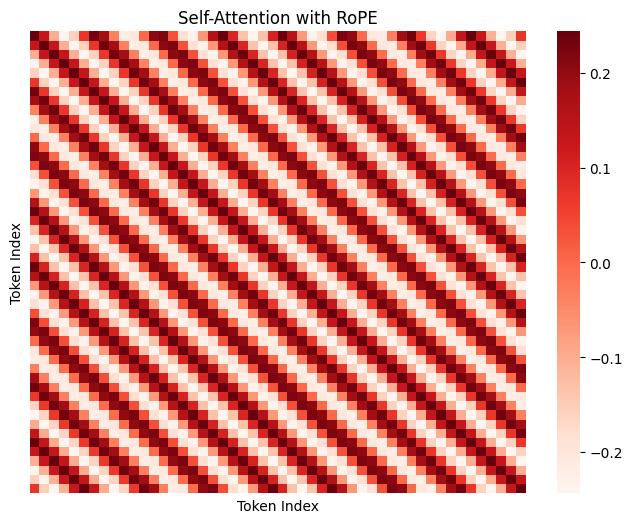

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def apply_rope(q, k):
    """Apply Rotary Positional Embeddings (RoPE) to query and key vectors."""
    seq_len, d_model = q.shape
    theta = 10_000 ** (-torch.arange(0, d_model, 2).float() / d_model)

    position = torch.arange(seq_len).float().unsqueeze(1)
    theta = position * theta.unsqueeze(0)

    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)

    q1, q2 = q[..., 0::2], q[..., 1::2]
    k1, k2 = k[..., 0::2], k[..., 1::2]

    q_rotated = torch.cat([q1 * cos_theta - q2 * sin_theta, q1 * sin_theta + q2 * cos_theta], dim=-1)
    k_rotated = torch.cat([k1 * cos_theta - k2 * sin_theta, k1 * sin_theta + k2 * cos_theta], dim=-1)

    return q_rotated, k_rotated

# Define sequence length and model dimension
seq_len = 50   # Number of positions (e.g., words in a sentence)
d_model = 64    # Embedding size (must be even)

# Simulate token embeddings (random values)
token_embeddings = torch.randn(seq_len, d_model)

print("Original Token Embeddings Shape:", token_embeddings.shape)

# Apply RoPE and visualize
q = torch.rand(1, d_model)
q = q.repeat(seq_len, 1)
k = q.clone()

q = q[:, :2]
k = k[:, :2]

attention_scores = torch.matmul(q, k.T)
q_rotated, k_rotated = apply_rope(q, k)

q_rotated = q_rotated[:, :2]
k_rotated = k_rotated[:, :2]

rope_attention_scores = torch.matmul(q_rotated, k_rotated.T)

# Visualize RoPE attention scores
plt.figure(figsize=(8, 6))
sns.heatmap(rope_attention_scores.numpy(), cmap="Reds", xticklabels=False, yticklabels=False)
plt.title("Self-Attention with RoPE")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.show()


# Efficient Attention


## Complexity

### Dimensions:

$$ \text{Attention}(\underset{\mathbb{R}^{n \times d_k}}{Q}, \underset{\mathbb{R}^{n \times d_k}}{K}, \underset{\mathbb{R}^{n \times d_v}}{V}) = \underset{\mathbb{R}^{n \times n}}{\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)} \underset{\mathbb{R}^{n \times d_v}}{V}
$$


Возможные решения:

1. **Инженерные трюки** - [FlashAttention](https://github.com/Dao-AILab/flash-attention/), [HIP Attention](https://github.com/DeepAuto-AI/hip-attention/), [FlashMLA](https://github.com/deepseek-ai/FlashMLA)

1. **Разреженные представления внимания** - [BigBird](https://arxiv.org/abs/2007.14062), [Longformer](https://arxiv.org/pdf/2004.05150)

2. **Линейные алгоритмы вычисления внимания** - [Performer](https://arxiv.org/abs/2009.14794), [Linformer](https://arxiv.org/abs/2006.04768)



## [FlashAttention](https://github.com/Dao-AILab/flash-attention)

Интересные факты:

* [Включено](https://pytorch.org/blog/pytorch2-2/) в ядро Pytorch из коробки - [**scaled_dot_product_attention**](https://pytorch.org/docs/2.2/generated/torch.nn.functional.scaled_dot_product_attention.html)
* Пилит один человек, пользуется вся индустрия

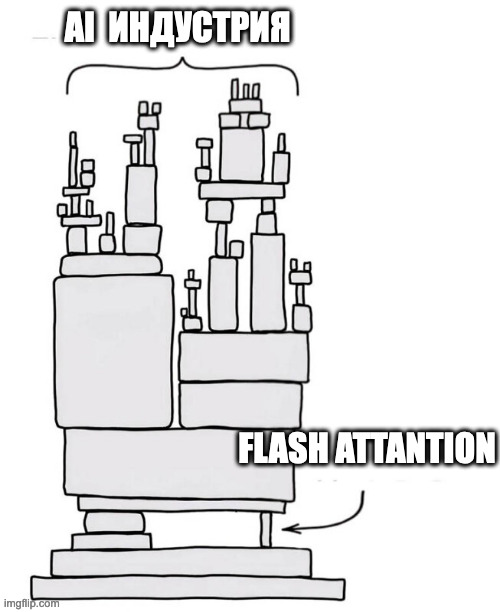


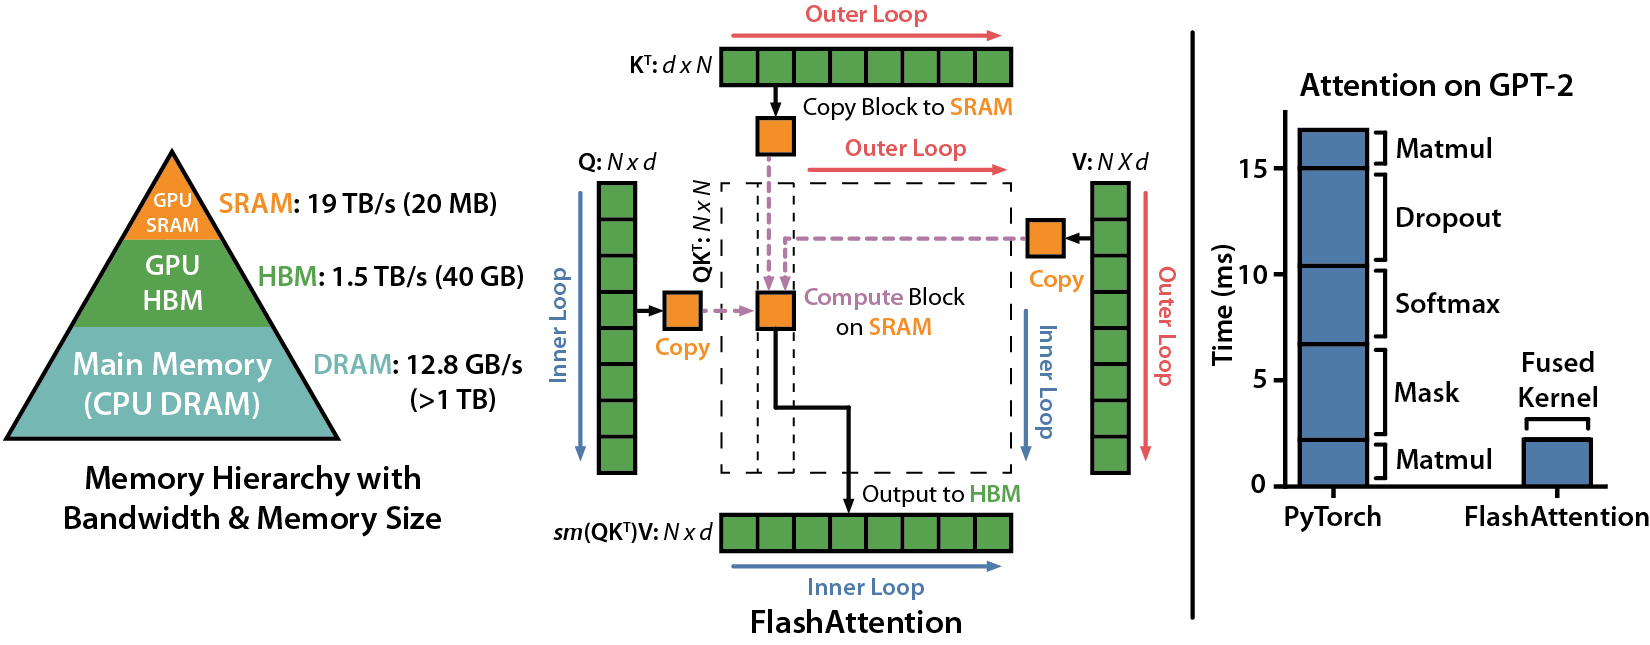

## Сравнение

**Идея:** За счет эффективной работы с памятью, можно увеличить количество вычислений, но сэкономить общее время вычисления, так как часто узкое место -- это именно загрузка/запись в память.


## EagerAttention

**Теоретическая вычислительная сложность:** $ O(N^2) $

**Эффективная вычислительная сложность:** $ O(N^2) $

**Сложность по памяти:** $ O(N^2) $

## FlashAttention

**Теоретическая вычислительная сложность:** $ O(N^2) $

**Эффективная вычислительная сложность:** $ O(N) $ ✅

**Сложность по памяти:** $ O(N) $ ✅

## [BigBird](https://arxiv.org/abs/2007.14062) (transformer-encoder)

**Идея:** Модифицируем маску для вычисления внимания.

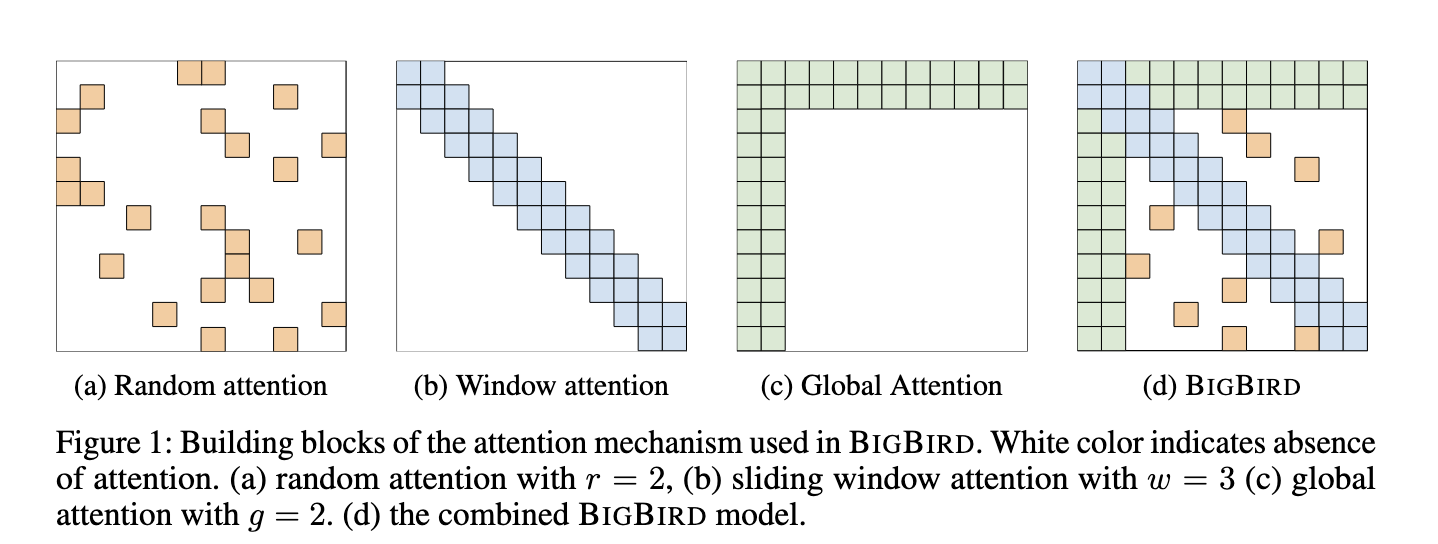

## Linformer

**Идея:** Можно сделать "трюк" в вычислении матрицы внимания $Q$, $K$ для того, чтобы уменьшить вычислительную сложность внимания.



## Сложность матричного умножения:

### Eager Attention

$d$ - скрытая размерность

$N$ - размерность длинны последовательности

$$ Q_{N \times d} \cdot  K_{N \times d}^T = Attention_{N \times N} $$

$$ Q_{N \times d} \cdot  K_{d \times N} = Attention_{N \times N} $$


Вычислитальная сложность $ O( N \times N \times d ) = $ O( N^2 ) $ $


### Linformer Attention

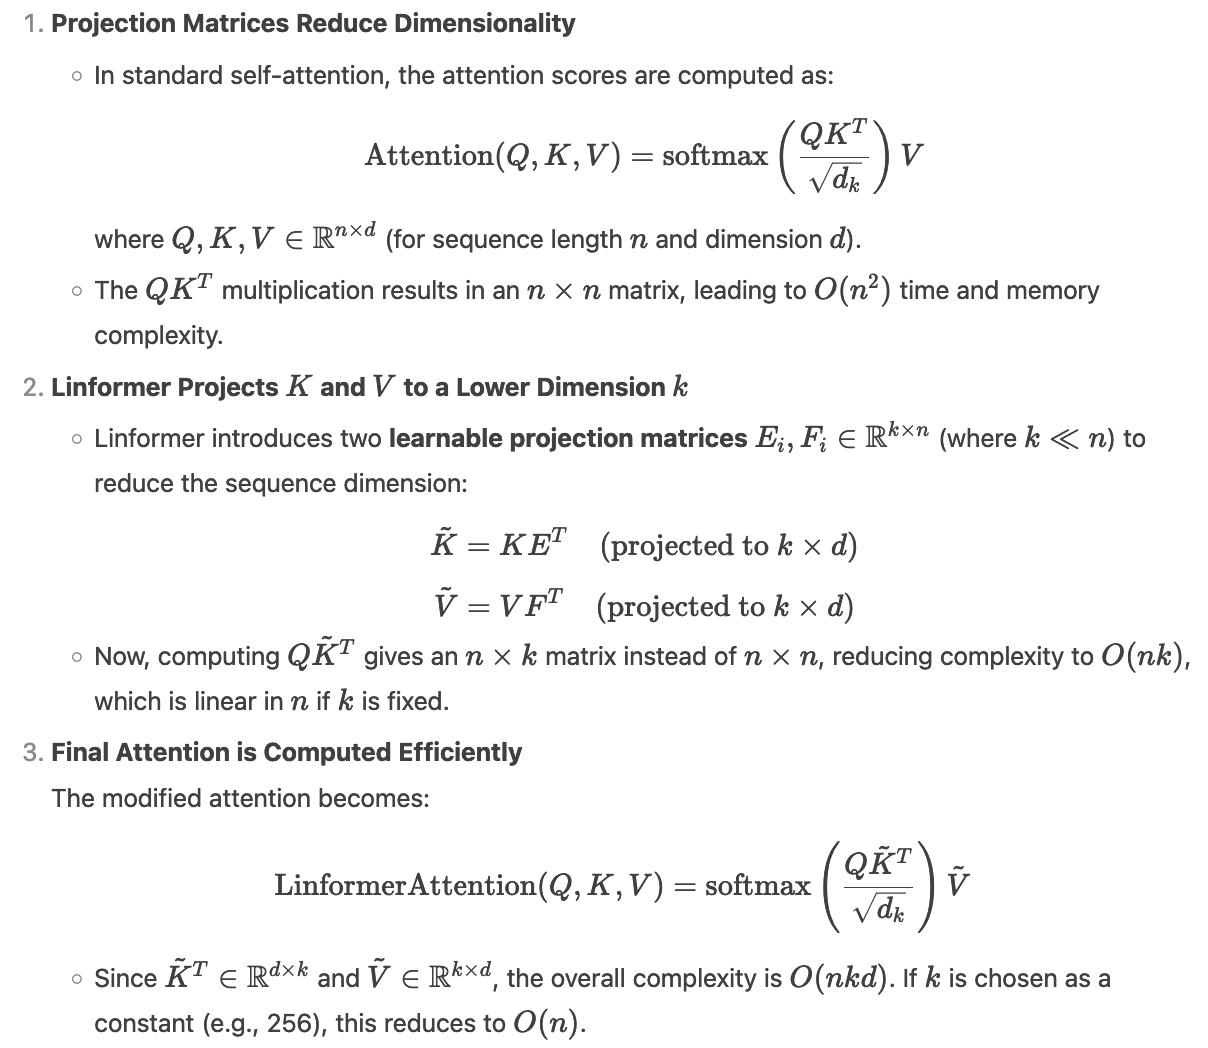


---

# [RNN + Transformer = RMT (Recurrent Memory Transformer)](https://arxiv.org/abs/2207.06881)

[Github](https://github.com/booydar/LM-RMT)

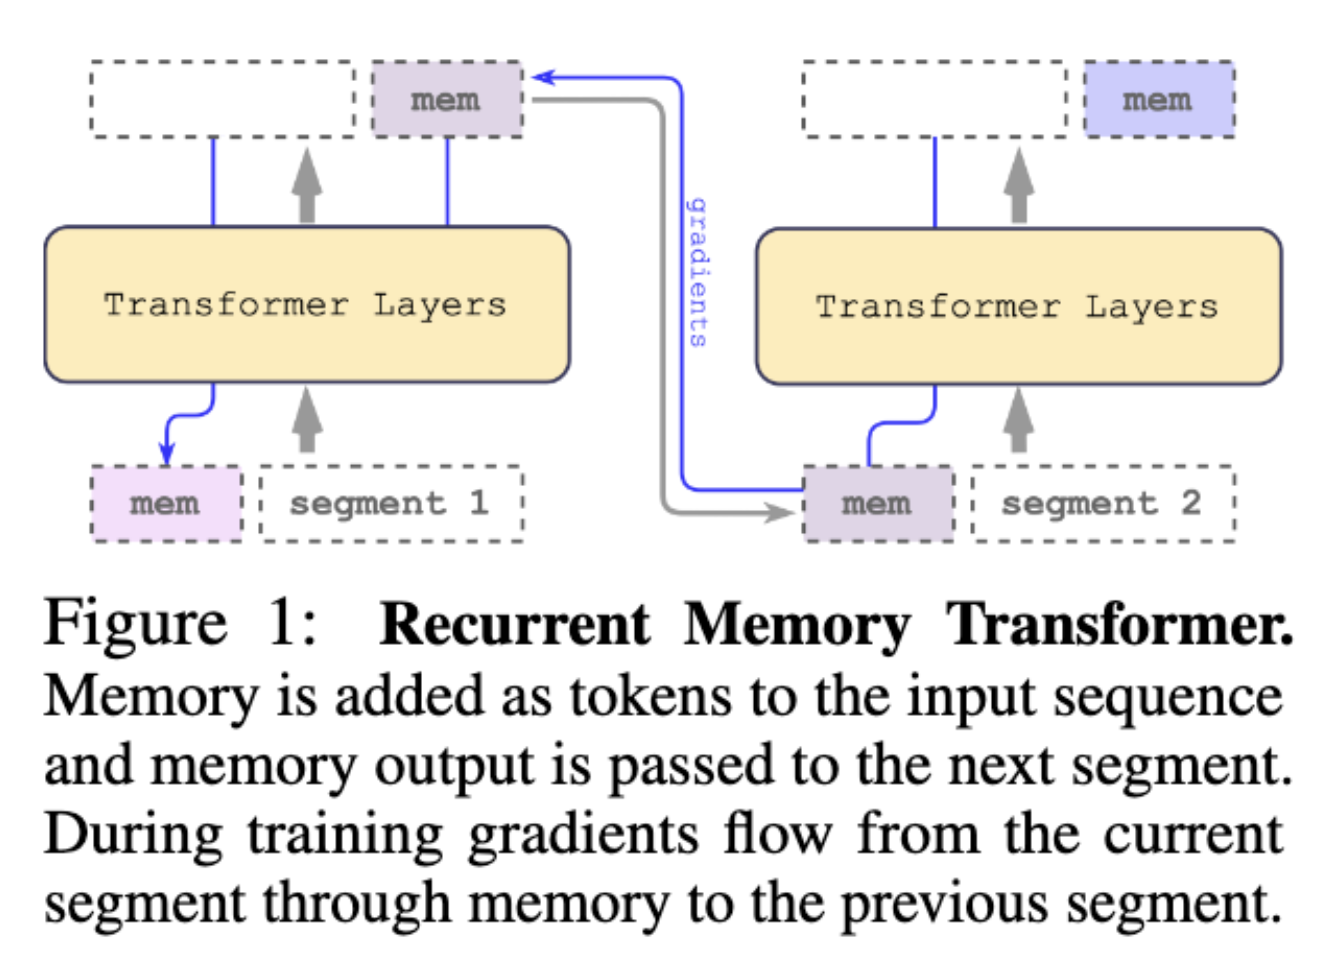


---

# [HuggingFace](https://huggingface.co/)

* [quicktour](https://huggingface.co/docs/transformers/quicktour)
* [training](https://huggingface.co/docs/transformers/training)

## Pipeline


In [ ]:
!pip install -q transformers

In [ ]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
classifier.model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
classifier("We are very happy to show you the 🤗 Transformers library.")

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

## Auto* Classes

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='nlptown/bert-base-multilingual-uncased-sentiment', vocab_size=105879, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
classifier("Nous sommes très heureux de vous présenter la bibliothèque 🤗 Transformers.")


[{'label': '5 stars', 'score': 0.7272651791572571}]

## Training (Finetuning)

In [ ]:
!pip install -q datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")
dataset["train"][100]


Reusing dataset yelp_review_full (/root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43)


  0%|          | 0/2 [00:00<?, ?it/s]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/13c31a618ba62568ec8572a222a283dfc29a6517776a3ac5945fb508877dde43/cache-a9ff008ff2e851c3.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
)


In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 375


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

# [FairSeq](https://github.com/pytorch/fairseq)

Если надо попробовать уже готовые модельки или есть идеи, как их можно улучшить


```
fairseq-train \
    data-bin/wmt14_en_de_distill \
    --save-dir checkpoints \
    --ddp-backend=legacy_ddp \
    --task translation_lev \
    --criterion nat_loss \
    --arch levenshtein_transformer \
    --noise random_delete \
    --share-all-embeddings \
    --optimizer adam --adam-betas '(0.9,0.98)' \
    --lr 0.0005 --lr-scheduler inverse_sqrt \
    --stop-min-lr '1e-09' --warmup-updates 10000 \
    --warmup-init-lr '1e-07' --label-smoothing 0.1 \
    --dropout 0.3 --weight-decay 0.01 \
    --decoder-learned-pos \
    --encoder-learned-pos \
    --apply-bert-init \
    --log-format 'simple' --log-interval 100 \
    --fixed-validation-seed 7 \
    --max-tokens 8000 \
    --save-interval-updates 10000 \
    --max-update 300000
```

# Еще материалы

### Материалы по RNN

##### Задача POS-tagging

##### **Вопрос**: чем LSTM/RNN лучше/хуже для задачи POS-tagging'а, чем MLP классификатор?


#### В отдельном [**ноутбуке**](https://colab.research.google.com/drive/1DMydkEt3mg8MagsMoitWHDUUWcjRa9Cd?usp=sharing)


Оригинальный [туториал](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)



* [Memorization in RNNs](https://distill.pub/2019/memorization-in-rnns/)
* [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

### Материалы по трансформерам

Код с комментариями и подробным разбором. Хотя имхо код не самый качественный, общую идею уловить можно.
http://nlp.seas.harvard.edu/2018/04/03/attention.html

https://jalammar.github.io/illustrated-transformer/

### Войта

* [seq2seq_and_attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)
* [the-story-of-heads](https://github.com/lena-voita/the-story-of-heads)

### HF Course

https://huggingface.co/course/


### Гугл)

Погуглите, если что-то еще интересно, или если хочется найти больше инфы по какой-то теме


# Блиц

# NLP

## Что такое эмбэддинг?

<!-- Эмбэддингом обычно назвают векторное представление какой-то сущности. Бывают эмбэддинги слов, предложений, документов, картинок, аудио, пользователей, товаров и т д -->


## Чем эмбэддинги `Word2Vec` или `FastText` отличаются от эмбэддингов `RNN`, `Transformer`?

<!-- RNN, Transformer позволяют получить эмбэддинг слова в текущем контексте и в зависимости от контекста эмбэддинг может быть разным. В W2V, FT эмбэддинги слов статичны. -->


## Чем LSTM/RNN лучше/хуже для задачи POS-tagging'а, чем MLP классификатор?

<!-- В MLP нет никакой инфромации о контексте. RNN'ки учитывают его за счет `hidden_state`'а


Можно перед MLP добавить слой `Attention` для решения этой проблемы, но в этом случае мы получим практически  трансформер -->


## Зачем нужен токенизатор?

<!-- Токенизатор отвечает за задачу разбиения строки на токены (или если упрощать, то не части слов) и преобразование каждого токена в целое число.


Если упрощенно, интерфейс токенизатора можно было бы прдеставить так:

```
def tokenize( text: str ) -> List[int]:
    pass
```
-->

# RNN

## Какие проблемы есть у RNN?

<!--
* долго обучается и вычисляется (а почему?)
* затухающие градиенты
* плохо работают с долгосрочными зависимостями (помнят лишь небольшой контекст)
* контекст учитывается только слева направо
-->


## Как они решаются в LSTM?

<!-- LSTM только пытается решить проблему
работы с длинным контекстом. Для этого вводится
 cell state, через который легко могут течь градиенты,
 тк в нем нет сигмоиды, которая бы могла приводить к затухающим градиентам. И кроме градиентов, через cell state в пярмом направлении тоже лучше распространяется информация
-->


## Чем GRU отличается от LSTM?

<!-- `GRU` меньше параметеров чем `LSTM` за счет меньшего количества гейтов. В `GRU` отказались от cell state.
-->


## Чем `LSTM(..., bidirectional=True)` отличается от `LSTM(..., num_layers=2)`

<!--
`LSTM(..., bidirectional=True)` -- сначала составляет эмбэддинги слева направа, а потом справа налево. В итоге получается 2 набора эмбэддингов, которые посчитали в разных направлениях.
Генерация с разных сторон позволяет лучше учитывать локальный контекст в начале длинной последовательности при обратном проходе.
По правде говоря, это просто костыль, попытка решить фундаментальную проблему плохой адаптируемости RNN к работе с длинными последовательностями)


`LSTM(..., num_layers=2)` -- оба набора эмбэддингов генерируются слева направо.
 -->

## Чем `RNN(..., bidirectional=True)` отличается от `RNN(..., num_layers=2)`

<!-- Эта механика не завимит от конкретной реализации RNN/LSTM/GRU - везде работает одинаково. Поэтому ответ на этот вопрос такой же как и на предыдущий -->


## Можно ли применить механизм внимания к RNN? Если да, то зачем тогда трансформеры вообще?

<!--
Применить можно - поверх RNN эмбэддингов - так даже делали какое-то время.

Применение механизма внимания к RNN делает их более выразительными. Но не решает многих проблем RNN: долгое и нестабильное обучение (без возможности распараллеливания).

Фундаментальная статья Attention Is All You Need потому и называется так, что
оказалось, что тушка RNN не нужна.
 -->


# Attention

## В чем различие `RNN + Attention` vs `Vanilla RNN`? Какую проблему решает механизм внимания? Чем мы жертвуем для решения этой проблемы?

<!-- Нет bottleneck одного вектора для Attention RNN. Жертвуем вычислительными ресурсами -->

## Зачем нужен **Scaled** Dot-Product Attention?

<!--

Скейл (деление на корень из размерности) позволяет лучше протекать градиентам.

Если не скейлить, то числа под софтмаксом получаются большими после перемножения матриц.
Большие по модулю числа в софтмаксе могут привести к сильному и значительному перевешиванию одного из чисел. Из-за чего градиенты по остальным интексам не потекут


https://ai.stackexchange.com/a/42197

```
import torch
import torch.nn as nn
sm = nn.Softmax(dim=0)

# предположим, что мы посчитали q @ k.T для размерности 256
# и в результате мы могли получить числа с СКО 16
attention_qkt = torch.tensor([ -16.0, -8.0, 0.0, 8.0, 16.0 ])

# not scaled softmax
sm( attention_qkt ) # tensor([1.2660e-14, 3.7739e-11, 1.1250e-07, 3.3535e-04, 9.9966e-01])

# scaled softmax
sm( attention_qkt / 16 ) # tensor([0.0580, 0.0956, 0.1577, 0.2600, 0.4287])
```

-->



## Чем MHA (Multi-Head-Attention) лучше SHA (Single-Head-Attention)?

<!--
                       MHA         SHA
Матричные операции     Больше      Меньше
Количество параметров  Примерно    Одинаково
Скорость вычислений    Примерно    Одинаково (тк MHA параллелятся вычисления)
Выразительность        Больше      Меньше

 -->




# Transformers

## Чем слой первичных эмбэддингов (неконтекстных) в трансформерах отличается от первичных эмбэддингов в RNN?

<!--
Ничем -- это один и тот же слой `nn.Embeddings`, используется тоже абсолютно одинаково.
 -->


## Сколько раз надо запустить Transformer Encoder, чтобы получить эмбэддинг последовательности для одного батча?

<!-- 1 -->

## Сколько раз надо запустить Decoder, чтобы сгенерировать последовательность длинны `M`, если длинна исходной последовательности `N`?

<!-- M -->

## Сколько раз нужно запустить Decoder в процессе обучения?

<!-- 1 -->

## Какие типы механизма внимания есть в трансформерах (отдельно в `Encoder`, отдельно в `Decoder`)?

<!--
* encoder - используется только self-attention
* dencoder - используется только self-attention + cross-attention
 -->


## Какие типы масок есть в трансформерах?

<!--
* casual mask - используется в декодере в self + cross attention для того, чтобы избежать заглядывания на будущие токены
* padding mask - для маскирования токенов паддинга
-->

## Сколько раз запускается RNN в процессе обучения для одного батча?

<!-- N + M -->

## Сколько раз запускается RNN в процессе вычисления для одного батча?

<!-- N + M -->

## Где и как еще можно применить механизм внимания?

<!-- Где угодно! Картинки, звук, временные ряды и т д -->


### Зависит ли количество параметров от длинны последовательности в `Transformer`? А в `RNN`?

<!-- Нет, не зависит ни для архитектур. Для трансформеров может зависеть только если используется обучаемый слой для Positional Embedding'ов  -->


## Зачем нужны позиционные эмбэддинги?

<!--

Механизм внимания никак не учитывает порядок токенов.
Тк при умножении можно переставить соответствующие строки и столбцы в матрицах и результат атеншна не изменится. Позиционные эмбэддинги должны привнести смещение для соответствующих токенов как раз для того, чтобы если это необходимо, модель могла их использовать.

 -->

-----

# Новые домашки: RNN-Attention, Transformer-Attention 🎉 🎉 🎉

